In [7]:
import numpy as np
from warpgbm import WarpGBM
import lightgbm as lgb
import time
import os
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [1]:
'''
Import Synthetic Memorization Dataset from Parascandolo et. al. https://arxiv.org/abs/2009.00329
'''

def download_file_if_missing(url, local_dir):
    filename = os.path.basename(url)
    local_path = os.path.join(local_dir, filename)

    if os.path.exists(local_path):
        print(f"✅ {filename} already exists, skipping download.")
        return

    # Convert GitHub blob URL to raw URL
    raw_url = url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

    print(f"⬇️  Downloading {filename}...")
    response = requests.get(raw_url)
    response.raise_for_status()

    os.makedirs(local_dir, exist_ok=True)
    with open(local_path, "wb") as f:
        f.write(response.content)
    print(f"✅ Saved to {local_path}")

urls = [
    "https://github.com/jefferythewind/era-splitting-notebook-examples/blob/main/Synthetic%20Memorization%20Data%20Set/X_train.npy",
    "https://github.com/jefferythewind/era-splitting-notebook-examples/blob/main/Synthetic%20Memorization%20Data%20Set/y_train.npy",
    "https://github.com/jefferythewind/era-splitting-notebook-examples/blob/main/Synthetic%20Memorization%20Data%20Set/X_test.npy",
    "https://github.com/jefferythewind/era-splitting-notebook-examples/blob/main/Synthetic%20Memorization%20Data%20Set/y_test.npy",
    "https://github.com/jefferythewind/era-splitting-notebook-examples/blob/main/Synthetic%20Memorization%20Data%20Set/X_eras.npy",
]


local_folder = "synthetic_data"

for url in urls:
    download_file_if_missing(url, local_folder)

⬇️  Downloading X_train.npy...
✅ Saved to synthetic_data/X_train.npy
⬇️  Downloading y_train.npy...
✅ Saved to synthetic_data/y_train.npy
⬇️  Downloading X_test.npy...
✅ Saved to synthetic_data/X_test.npy
⬇️  Downloading y_test.npy...
✅ Saved to synthetic_data/y_test.npy
⬇️  Downloading X_eras.npy...
✅ Saved to synthetic_data/X_eras.npy


In [4]:
'''
Load the real dataset from local .npy files
'''
data_dir = "synthetic_data"
X = np.load(os.path.join(data_dir, "X_train.npy"))
y = np.load(os.path.join(data_dir, "y_train.npy"))
eras = np.load(os.path.join(data_dir, "X_eras.npy"))

X_test = np.load(os.path.join(data_dir, "X_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))

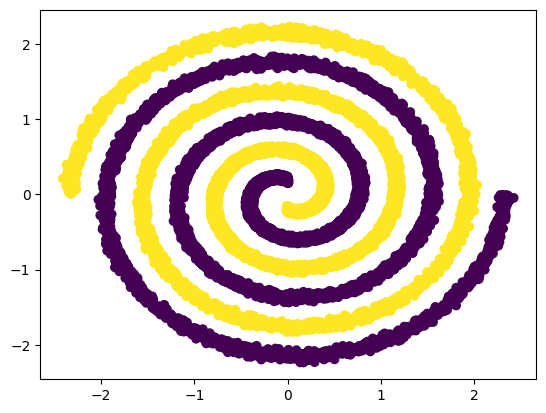

In [6]:
'''
Scatter Plot of the first two dimensions colored by target value

The invariant signal is encoded in the first two dimensions
'''
plt.scatter(X[:,0], X[:,1], c=y)

In [17]:
'''
Naive LightGBM ( or WarpGBM) fails to learn the invariant signal, at test time, it fails

'''

print(f"X shape: {X.shape}, y shape: {y.shape}")

model = lgb.LGBMRegressor(
    max_depth=10,
    max_bin=127,
    n_estimators=50,
    learning_rate=1,
    colsample_bytree=0.9,
    min_child_weight=4
)

start_fit = time.time()
model.fit(
    X,
    y
)
fit_time = time.time() - start_fit
print(f"  Fit time:     {fit_time:.3f} seconds")

start_pred = time.time()
preds = model.predict(X_test)
pred_time = time.time() - start_pred
print(f"  Predict time: {pred_time:.3f} seconds")

corr = np.corrcoef(preds, y_test)[0, 1]
mse = mean_squared_error(preds, y_test)
print(f"  Correlation:  {corr:.4f}")
print(f"  MSE:          {mse:.4f}")

if corr < 0.95: 
    print( f"Out-of-sample correlation too low: {corr:.4f}" )
if mse > 0.02: 
    print( f"Out-of-sample MSE too high: {mse:.4f}" )

X shape: (12288, 18), y shape: (12288,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 12288, number of used features: 18
[LightGBM] [Info] Start training from score 0.500407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further spli

/home/jefferythewind/anaconda3/envs/ml311_dev/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


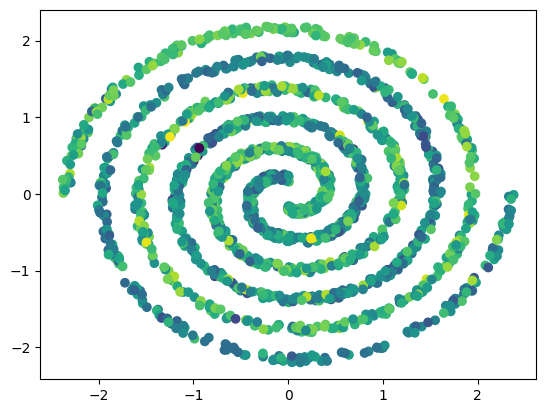

In [19]:
'''
Plot decision surface over invariant signal
'''
plt.scatter(X_test[:,0], X_test[:,1], c=preds)

In [20]:
'''
Naive LightGBM ( or WarpGBM) fails to learn the invariant signal, at test time, it fails

'''

print(f"X shape: {X.shape}, y shape: {y.shape}")

model = WarpGBM(
    max_depth=10,
    num_bins=127,
    n_estimators=50,
    learning_rate=1,
    threads_per_block=128,
    rows_per_thread=4,
    colsample_bytree=0.9,
    min_child_weight=4
)

start_fit = time.time()
model.fit(
    X,
    y,
    era_id=era
)
fit_time = time.time() - start_fit
print(f"  Fit time:     {fit_time:.3f} seconds")

start_pred = time.time()
preds = model.predict(X_test)
pred_time = time.time() - start_pred
print(f"  Predict time: {pred_time:.3f} seconds")

corr = np.corrcoef(preds, y_test)[0, 1]
mse = mean_squared_error(preds, y_test)
print(f"  Correlation:  {corr:.4f}")
print(f"  MSE:          {mse:.4f}")

if corr < 0.95: 
    print( f"Out-of-sample correlation too low: {corr:.4f}" )
if mse > 0.02: 
    print( f"Out-of-sample MSE too high: {mse:.4f}" )

X shape: (12288, 18), y shape: (12288,)
quantile binning.
Finished training forest.
  Fit time:     19.231 seconds
  Predict time: 0.497 seconds
  Correlation:  0.9722
  MSE:          0.0138


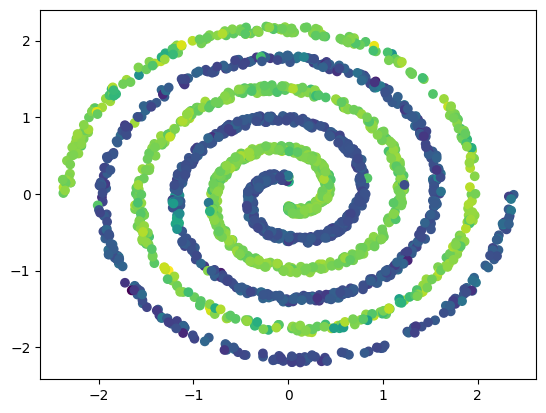

In [21]:
'''
Plot decision surface over invariant signal
'''
plt.scatter(X_test[:,0], X_test[:,1], c=preds)